In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from labbench import stopwatch
import matplotlib.pyplot as plt
from sea_ingest import trace


def envtodB(env):
    return 20 * np.log10(env)


def powtodB(pow):
    return 10 * np.log10(pow)


def dBtoenv(env):
    return 10 ** (env / 20)


def dBtopow(pow):
    return 10 ** (pow / 10)


data_path = Path("data")
plt.style.use("report.mplstyle")
# %config InlineBackend.figure_formats = ['svg'] # display in notebook as svg

#### Load data

In [4]:
import dask
import sea_ingest

with stopwatch():
    ddfs = sea_ingest.read_seamf_zipfile_as_ddf(
        data_path / "NIT-2022-12-13.zip",
        tz="America/New_York",
        localize=False,
        partition_size=300,
    )

    day_ddfs = {
        k: ddfs[k].loc["2022-11-01"] for k in ("psd", "pfp", "pvt", "channel_metadata")
    }

    day = dask.compute(day_ddfs)[0]
    sea_ingest.restore_multiindex(day)

    for table_name in ("psd", "pfp", "pvt"):
        day[table_name] = day[table_name].astype("float32")

 INFO   2024-03-07 09:22:19.729 • labbench: 5.936 s elapsed


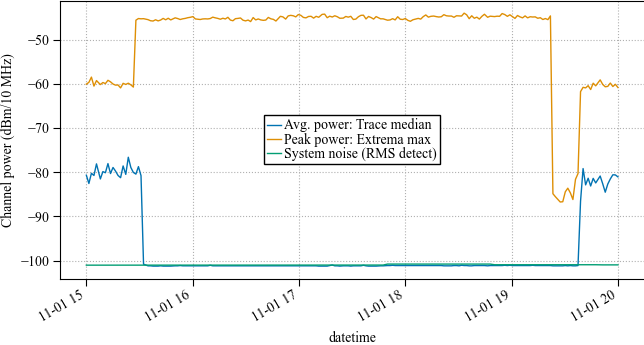

In [5]:
freq = 3605e6

noise_figure = sea_ingest.trace(
    day, "channel_metadata", "cal_noise_figure_dB", frequency=freq
)
avg_power = (
    sea_ingest.trace(
        day, "pfp", frequency=freq, capture_statistic="mean", detector="rms"
    )
    .quantile(0.5, axis=1)
)
peak_power = (
    sea_ingest.trace(
        day, "pfp", frequency=freq, capture_statistic="max", detector="peak"
    )
    .max(axis=1)
)

noise_figure = pd.Series(
    noise_figure.values[noise_figure.index.get_indexer(avg_power.index, method='nearest')],
    index=avg_power.index
)

pfp_indicators = pd.DataFrame(
    {
        "Avg. power: Trace median": avg_power.values,
        "Peak power: Extrema max": peak_power.values,
        "System noise (RMS detect)": (noise_figure + -174 + 70 - 1).values,
    },
    index = avg_power.index
)

(
    pfp_indicators.loc["2022-11-01 15:00:00":"2022-11-01 20:00:00"].plot(
        ylabel="Channel power (dBm/10 MHz)"
    )
);

In [6]:
from scipy import signal


def circular_diff(a, count=1, axis=0):
    return a - np.roll(a, count, axis=axis)


def roll(a, shifts):
    """rolls `a` along axis 0 (row-wise) according to `shifts` vector"""
    # https://stackoverflow.com/questions/72876029/numpy-roll-horizontally-on-a-2d-ndarray-with-different-values
    a = a.T
    shifts = shifts[np.newaxis, :].T
    return a[np.c_[: a.shape[0]], (np.r_[: a.shape[1]] - shifts) % a.shape[1]].T


def make_3gpp_downlink_mask(length, tdd_config=2):
    """industry has emphasized two different TDD frame configurations for coexistence.

    Arguments:
        length: number of power samples in the TDD frame
        tdd_config: either 1 or 2
    """
    if tdd_config == 1:
        dl_duty = (5 + 3 / 7) / 10.0
    elif tdd_config == 2:
        dl_duty = (7 + 3 / 7) / 10.0
    else:
        raise ValueError("tdd_config must be one of (1,2)")
    Ndl = np.rint((length // 2) * dl_duty).astype(int)
    return np.array(2 * (Ndl * [True] + (length // 2 - Ndl) * [False]))


def corr_along_axis0(a: np.ndarray, template: np.ndarray, norm=True, diff=False):
    """correlates the 0th axis of ndarray `a` against a template vector.

    Args:
        norm: if True, output will be normalized as pearson correlation coefficients
        diff: if True, correlate on the difference vector
    """
    # this makes the convolution -> correlation
    template = template[::-1]

    if diff:
        # correlate on the difference vector
        a = np.diff(a, axis=0)
        template = np.diff(template, axis=0)[:, np.newaxis] * np.ones_like(a)
    else:
        shape = np.broadcast_shapes(a.shape, template.shape)

        # correlate
        template = np.broadcast_to((template - template.mean()), shape)
        a = np.broadcast_to(a - a.mean(axis=0)[np.newaxis, :], shape)

    ret = signal.fftconvolve(a, template, mode="same", axes=0) / (a.shape[0])
    if norm:
        ret /= a.std(axis=0) * template.std(axis=0)
    else:
        ret /= template.std(axis=0) / 2

    return ret


def argmax_first_n(a, ndim):
    max_idx = a.reshape((np.prod(a.shape[:ndim]), -1)).argmax(axis=0)
    max_idx = np.unravel_index(max_idx, a.shape[:ndim])

    return max_idx


def sync_pfp_to_frame(dfs: dict, norm=False, **trace_kws) -> tuple:
    # the mean rms trace seems to perform as well as anything else for identifying
    # the sample shift correction
    ref_pfp = trace(dfs, "pfp", capture_statistic="mean", detector="rms", **trace_kws)
    ref_pfp = ref_pfp.T.astype("float32")

    # masks for both of the standard types of 3GPP waveform
    dl_masks = np.array(
        [
            make_3gpp_downlink_mask(ref_pfp.shape[0], 1),
            make_3gpp_downlink_mask(ref_pfp.shape[0], 2),
        ]
    ).T

    # correlate, and identify index peak in the correlation functions
    corrs = corr_along_axis0(
        10 ** (ref_pfp.values[:, np.newaxis] / 20), dl_masks[..., np.newaxis], norm=norm
    )
    offsets, frame_types = argmax_first_n(corrs, 2)

    # package
    shifts = pd.Series(-offsets, index=ref_pfp.columns, name="shifts")
    corr_info = pd.DataFrame(
        {
            "shift": -offsets,
            "peak": np.max(corrs, axis=(0, 1)),
            "frame_format": frame_types,
        },
        index=ref_pfp.columns,
    )

    full_pfp = trace(dfs, "pfp").T.astype("float32")
    ext_shifts = shifts.loc[full_pfp.columns.droplevel(full_pfp.index.names[2:])].values
    full_pfp.values[:] = roll(full_pfp.values, ext_shifts)

    return (full_pfp.T, corr_info, dl_masks)


def midmean(a, qlo=0.25, qhi=0.75, axis=0):
    lo, hi = np.nanquantile(a, [qlo, qhi], axis=axis, keepdims=True)

    # TODO: this could likely be made faster with string query expressions
    if isinstance(a, (pd.DataFrame, pd.Series)):
        return a.mask((a.values < lo) | (a.values > hi)).mean(axis=axis)
    else:
        return np.nanmean(np.where((a >= lo) & (a < hi), np.nan, a), axis=axis)


day_traces, day_corr_info, dl_masks = sync_pfp_to_frame(day, norm=False)

# traces = pd.DataFrame(np.roll(traces.values, -shift, axis=0), index=traces.index, columns=traces.columns)
# fig, ax = plt.subplots(figsize=(11,5))
# traces.iloc[:,:].plot(ax=ax, legend=False, rasterized=True)

print(
    "corr peak max/mean/median/min: ",
    day_corr_info.peak.values.max(),
    np.mean(day_corr_info.peak.values),
    np.quantile(day_corr_info.peak.values, 0.5),
    day_corr_info.peak.values.min(),
);

corr peak max/mean/median/min:  0.0009069503371765059 0.00011375519867503137 7.631015158371526e-05 3.4882682343998265e-08


### Plots of TDD frame-aligned PFP

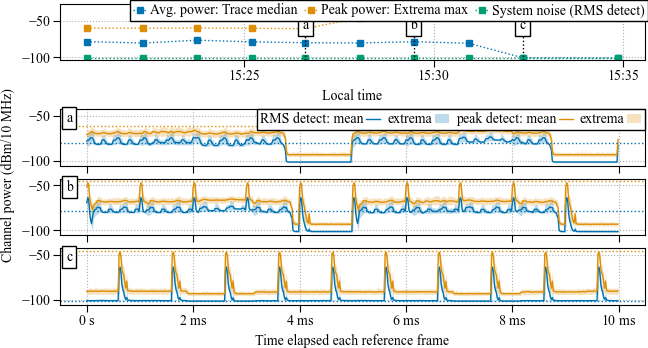

In [9]:
from sea_ingest.plots import (
    nearest_datetimes,
    plot_pfp_span_with_detail,
    plot_pvt_detail,
    plot_psd_detail,
)

plt.style.use("report.mplstyle")

detail_trace_targets = {
    "a": "2022-11-01 15:26",
    "b": "2022-11-01 15:30",
    "c": "2022-11-01 15:33",
}
mid_span = slice("2022-11-01 15:20:00", "2022-11-01 15:35:00")

detail_datetimes = {
    k: nearest_datetimes(pfp_indicators, [v])[0]
    for k, v in detail_trace_targets.items()
}

plot_pfp_span_with_detail(day_traces, freq, pfp_indicators, mid_span, detail_datetimes);
# plot_pvt_detail(day, freq, detail_datetimes)
# plot_psd_detail(day, detail_datetimes)

/var/folders/4c/2cryg6ld5b10g45f5cpsrf740016fl/T/ipykernel_16704/186552825.py:28: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.autofmt_xdate(rotation=0, ha="center")


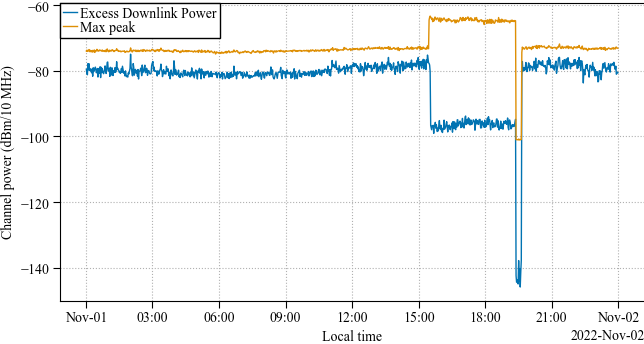

In [10]:
from matplotlib.dates import ConciseDateFormatter, AutoDateLocator

freq_traces = trace(day_traces, frequency=freq)
corr_info = trace(day_corr_info, frequency=freq)

all_power = (
    freq_traces
    # .mask(bool_mask.values)
    .pipe(trace, capture_statistic="mean", detector="rms")
)

fig, ax = plt.subplots()

((corr_info.peak * np.sqrt(2)).pipe(envtodB).plot(ax=ax, label="Excess Downlink Power"))


# trace_rms.plot(ax=ax,label='Trace RMS')
# ul_power.max(axis=1).plot(ax=ax,label='UL max')
# dl_power.max(axis=1).plot(ax=ax,label='DL max')
all_power.max(axis=1).plot(
    ax=ax, label="Max peak", xlabel="Local time", ylabel="Channel power (dBm/10 MHz)"
)
ax.legend()

locator = AutoDateLocator()
ax.xaxis.set_major_formatter(ConciseDateFormatter(locator))
ax.xaxis.set_major_locator(locator)
fig.autofmt_xdate(rotation=0, ha="center")
# plt.plot(traces.columns, 10*np.log10(np.max(10**(traces.astype('float32')/10),axis=0)), label='Peak power')
# print(detect_3gpp.mean(), detect_3gpp.min())

### Aggregation of PFP across longer time scales
Alignment to the TDD frame structure allows meaningful aggregation across multiple captures. In the following, 

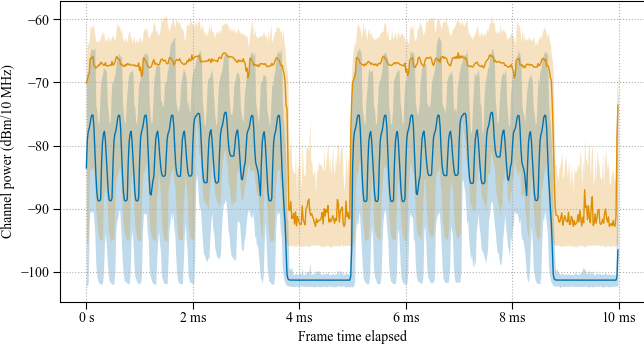

In [11]:
from matplotlib.ticker import EngFormatter

agg_span = slice(None, "2022-11-01 11:00:00")
# agg_span = slice('2022-11-01 16:00:00', '2022-11-01 19:00:00')

fig, ax = plt.subplots()

for detector, color in dict(rms="C0", peak="C1").items():
    agg_mean = (
        day_traces.pipe(
            trace, frequency=freq, capture_statistic="mean", detector=detector
        )
        .loc[agg_span]
        .pipe(dBtopow)
        .apply(np.max if detector == "peak" else np.mean, axis=0)
        .pipe(powtodB)
    )

    agg_max = (
        day_traces.pipe(
            trace, frequency=freq, capture_statistic="max", detector=detector
        )
        .loc[agg_span]
        .max(axis=0)
    )

    agg_min = (
        day_traces.pipe(
            trace, frequency=freq, capture_statistic="min", detector=detector
        )
        .loc[agg_span]
        .min(axis=0)
    )

    agg_mean.plot(
        ax=ax,
        color=color,
        xlabel="Frame time elapsed",
        ylabel="Channel power (dBm/10 MHz)",
    )

    ax.fill_between(
        agg_min.index.values.astype("float32"),
        agg_min.values,
        agg_max.values,
        alpha=0.25,
        color=color,
        lw=0,
    )

    ax.xaxis.set_major_formatter(EngFormatter(unit="s"))

### Uplink vs downlink power
The time-aligned PFP power trace can be used to compute DL and UL power independently. 

/var/folders/4c/2cryg6ld5b10g45f5cpsrf740016fl/T/ipykernel_16704/1643156848.py:64: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.autofmt_xdate(rotation=0, ha="center");


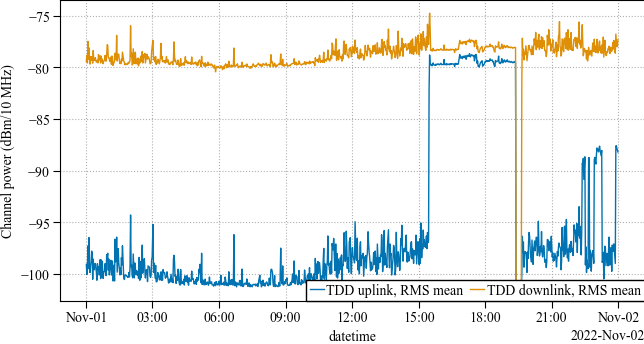

In [12]:
# use the downlink mask to flag uplink vs downlink indices
bool_mask = pd.DataFrame(
    dl_masks[:, corr_info.frame_format.values].T,
    index=corr_info.index,
    columns=freq_traces.columns,
)
bool_mask = bool_mask.loc(axis=0)[freq_traces.index.get_level_values(0)]


dl_power = freq_traces.mask(~bool_mask.values).pipe(
    trace, capture_statistic="mean", detector="rms"
)

ul_power = freq_traces.mask(bool_mask.values).pipe(
    trace, capture_statistic="mean", detector="rms"
)

# dl_excess = powtodB(midmean(dBtopow(dl_power), 0.1, 0.9, axis=1)/midmean(dBtopow(ul_power),0.1,0.9,axis=1)-1)

trace_rms = (
    freq_traces.pipe(dBtopow)
    .mean(axis=1)
    .pipe(powtodB)
    .reset_index(["capture_statistic", "detector"])
)

fig, ax = plt.subplots()

# (
#     ul_power
#     .pipe(dBtopow)
#     .pipe(midmean, 0.25, 0.75, axis=1)
#     .pipe(powtodB)
#     .plot(ax=ax,label='UL RMS, mean of center 50%')
# )

# (
#     dl_power
#     .pipe(dBtopow)
#     .pipe(midmean, 0.25, 0.75, axis=1)
#     .pipe(powtodB)
#     .plot(ax=ax,label='DL mean of center 50%',xlabel='Local time', ylabel='Channel power (dBm/10 MHz)')
# )


(
    ul_power.pipe(dBtopow)
    .mean(axis=1)
    .pipe(powtodB)
    .plot(ax=ax, label="TDD uplink, RMS mean")
)

(
    dl_power.pipe(dBtopow)
    .mean(axis=1)
    .pipe(powtodB)
    .plot(ax=ax, label="TDD downlink, RMS mean", ylabel="Channel power (dBm/10 MHz)")
)

ax.legend(loc="lower right", ncol=2)
locator = AutoDateLocator()
ax.xaxis.set_major_formatter(ConciseDateFormatter(locator))
ax.xaxis.set_major_locator(locator)
fig.autofmt_xdate(rotation=0, ha="center");
# ax.xaxis.set_major_formatter(EngFormatter(unit='s'));

In [13]:
# fig, ax = plt.subplots()
# dl_rms = 10*np.log10(np.mean(10**(dl_power/10),axis=1))

# (dl_power.max(axis=1)-dl_rms).plot(label='Peak to average ratio', ax=ax)
# ((20*np.log10(corr_info.peak*np.sqrt(2)))-dl_rms).plot(label='3GPP to average ratio', ax=ax)
# # dl_excess.plot(ax=ax,label='Excess DL ratio')
# ax.legend(title='Power statistics in 3GPP downlink window', loc='lower left')


# print((20*np.log10(corr_info.peak*np.sqrt(2))-dl_rms).iloc[:300].mean())